In [0]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
import matplotlib.pyplot as plt

np.random.seed(10)

### 匯入Mnist資料集

In [0]:
from keras.datasets import mnist

In [0]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


---

### 查看訓練資料

In [0]:
# 查看mnist資料
print('train data=', len(X_train_image))
print(' test data=', len(X_test_image))

# 查看mnist訓練資料維度
print('X_train data =', X_train_image.shape)
print('y_train data =', y_train_label.shape)

train data= 60000
 test data= 10000
X_train data = (60000, 28, 28)
y_train data = (60000,)


* 為了顯示image圖像，先定義函數顯示圖像資料

In [0]:
def plot_image(image):
  fig = plt.gcf()
  fig.set_size_inches(2, 2)
  plt.imshow(image, cmap='gray')
  plt.show()

* 執行觀察訓練集圖像

5


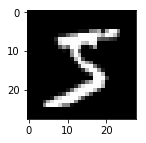

None


In [0]:
print(y_train_label[0])
print(plot_image(X_train_image[0]))

* 上面函數只能查看單個圖像，下面做一個可以查看多個圖像的函數，方便後面進行觀看X與y比較的結果

In [0]:
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
  
  fig = plt.gcf()
  fig.set_size_inches(12, 14)
  
  if num>25:
    num = 25
  
  for i in range(0, num):
    ax = plt.subplot(5, 5, 1+i)
    ax.imshow(images[idx], cmap='gray')
    title = 'label=' + str(labels[idx])
    if len(prediction) > 0:
      title += ', predict=' + str(prediction[idx])
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    idx += 1
  
  plt.show()

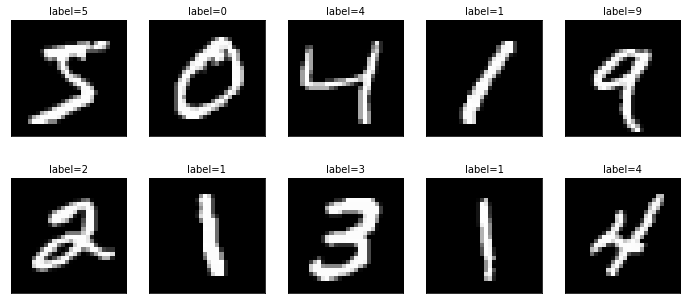

In [0]:
# 查看前10筆訓練資料
plot_images_labels_prediction(X_train_image, y_train_label, [], 0, 10)

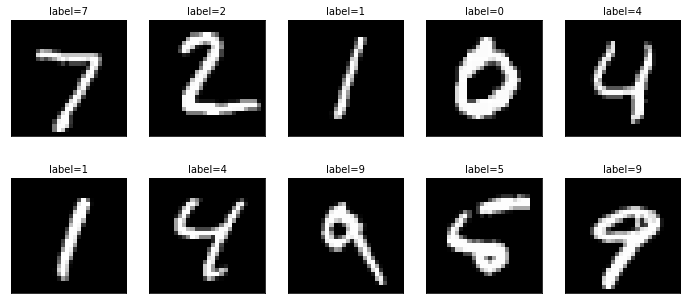

In [0]:
# 查看測試集前10筆資料
plot_images_labels_prediction(X_test_image, y_test_label, [], 0, 10)

----

### 多層感知器資料預處理

* 因為要用多層感知器(multilayer perception)作為模型訓練資料，故需要先對資料的image與label做資料預處理

#### Features(image)資料預處理

* 要對Feature(數字影響特徵值)做兩步驟處理:
1. 將原本28x28的影像以reshape轉換為一維的向量，並轉換型態為float
2. 將數字影像image做標準化

* 查看image的shape

In [0]:
print('X_train_image:', X_train_image.shape)
print('X_test_image:', X_test_image.shape)

X_train_image: (60000, 28, 28)
X_test_image: (10000, 28, 28)


* 將image做reshape轉換

In [0]:
X_Train = X_train_image.reshape(60000, 28*28).astype('float32')
X_Test = X_test_image.reshape(10000, 28*28).astype('float32')

* 查看轉換為1維後的向量

In [0]:
print('X_Train:', X_Train.shape)
print('X_Test:', X_Test.shape)

X_Train: (60000, 784)
X_Test: (10000, 784)


* 對image做[0,1]正規化  →  目的：排除彼此間單位的不同或數據的極大落差

In [0]:
# 確認最大數是多少?
max(X_Train[0])

255.0

In [0]:
X_Train_Normalization = X_Train / 255
X_Test_Normalization = X_Test / 255

#### Label(數字影像真實值)資料預處理

* 數字0~9是一組有排序，有大小的分類組合，由於我們的目的是辨別圖像內的數字，故不需要有大小與排序的分類，只要單純的分類組合，因此需要做One-hot encoding編碼。

* 查看原排列組合

In [0]:
print(y_train_label[0:5])
print(y_test_label[0:5])

[5 0 4 1 9]
[7 2 1 0 4]


* 做One-hot encoding編碼

In [0]:
y_Train_OneHotEncoding = np_utils.to_categorical(y_train_label)
y_Test_OneHotEncoding = np_utils.to_categorical(y_test_label)

* 比較編碼前後的排列方式

In [0]:
print(y_train_label[:5])
print(y_Train_OneHotEncoding[:5])

print(y_test_label[:5])
print(y_Test_OneHotEncoding[:5])


[5 0 4 1 9]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[7 2 1 0 4]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---

### 建立MLP模型─多元感知器(MLP，Multilayer Perception)

* Step1. 匯入所需模組

In [0]:
from keras.models import Sequential
from keras.layers import Dense

* Step2. 建立Sequential模型

In [0]:
model = Sequential()

* Step3. 建立「輸入層」與「隱藏層」

In [0]:
model.add(Dense(units = 256, # 定義隱藏層神經元個數256個 
                input_dim = 784,  # 設定輸入層神經元784個
                kernel_initializer = 'normal',  # 使用normal distribution常態分佈的亂數，初始化weight bias
                activation = 'relu'  # 定義激活函數為relu
               )
         )

* Step4. 建立「輸出層」

In [0]:
model.add(Dense(units = 10,  # 定義「輸出層」為10個(不用定義input，因為前面的隱藏層神經元256個已經定義好了)
                kernel_initializer = 'normal',
                activation = 'softmax'
               )
         )

* Step5. 查看模型摘要(確認建立的模型架構)

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


確認所有需要訓練的Param(參數)有203,530個 = 200,960(784x256+256) + 2,570(256x10+10)

### 進行訓練

#### STEP1. 定義訓練方式(對模型進行設定)

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
             )

compile方法的參數說明：
* loss：損失函數(loss function)，通常在深度學習會使用cross_entropy(交叉熵)，訓練效果較好
* optimizer：優化函數，設定訓練時最優化方法，在深度學習通常會使用adam讓訓練更快收斂
* metrics：成效衡量指標，設定評估模型的指標為accuracy(準確率)

#### STEP2. 開始訓練

In [0]:
train_history = model.fit(x = X_Train_Normalization,
                          y = y_Train_OneHotEncoding,
                          validation_split = 0.2,  # 驗證資料比例20%
                          epochs = 10,  # 訓練週期
                          batch_size = 200,  # 每次訓練批數200筆資料
                          verbose = 2  # 顯示訓練過程
                         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 3s - loss: 0.4440 - acc: 0.8820 - val_loss: 0.2268 - val_acc: 0.9362
Epoch 2/10
 - 2s - loss: 0.1952 - acc: 0.9446 - val_loss: 0.1636 - val_acc: 0.9537
Epoch 3/10
 - 2s - loss: 0.1399 - acc: 0.9592 - val_loss: 0.1305 - val_acc: 0.9635
Epoch 4/10
 - 2s - loss: 0.1068 - acc: 0.9697 - val_loss: 0.1119 - val_acc: 0.9688
Epoch 5/10
 - 2s - loss: 0.0854 - acc: 0.9760 - val_loss: 0.1017 - val_acc: 0.9708
Epoch 6/10
 - 2s - loss: 0.0687 - acc: 0.9811 - val_loss: 0.0930 - val_acc: 0.9712
Epoch 7/10
 - 2s - loss: 0.0569 - acc: 0.9848 - val_loss: 0.0914 - val_acc: 0.9717
Epoch 8/10
 - 2s - loss: 0.0477 - acc: 0.9870 - val_loss: 0.0897 - val_acc: 0.9730
Epoch 9/10
 - 2s - loss: 0.0397 - acc: 0.9895 - val_loss: 0.0828 - val_acc: 0.9759
Epoch 10/10
 - 2s - loss: 0.0325 - acc: 0.9918 - val_loss: 0.0797 - val_acc: 0.9762


#### STEP3. 建立函式(show_train_history)以圖表顯示訓練過程

In [0]:
def show_train_history(train_history, train, validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')  # 顯示圖例於左上
  plt.show()

#### STEP4. 畫出accuracy執行結果

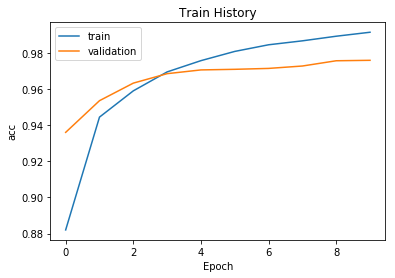

In [0]:
show_train_history(train_history, 'acc', 'val_acc')

為何在10個訓練週期中，後期train的準確率比validation高?
* train訓練準確率：好像老師上過課的測驗題，考試從中間抽出來考，答對會比較多。(但容易有Overfitting的問題)
* validation訓練準確率：老師上課測驗，但考試是拿獨立的題庫進行考試，準確率長期以來一定比較train低

#### STEP5. 畫出loss誤差值行結果

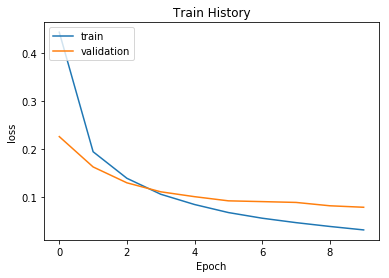

In [0]:
show_train_history(train_history, 'loss', 'val_loss')

### 以測試資料評估模型準確率

* 使用TEST資料進行模型評估(完全獨立於訓練資料的資料，比驗證的數據更客觀)

#### STEP1. 評估模型準確率

In [0]:
scores = model.evaluate(X_Test_Normalization, y_Test_OneHotEncoding)
print()
print('accuracy=', scores[1])

10000/10000 [==============================] - 0s 34us/step

accuracy= 0.9778


### 進行預測

#### STEP1. 執行預測

In [0]:
prediction = model.predict_classes(X_Test)  # 使用predict_classes是返回類別索引；使用predict是返回數值(類別的概率)

#### STEP2. 預測結果

In [0]:
print(prediction)

[7 2 1 ... 4 5 6]


#### STEP3. 顯示預測結果(10筆) (利用前面所建立比較多筆image與label的函式)

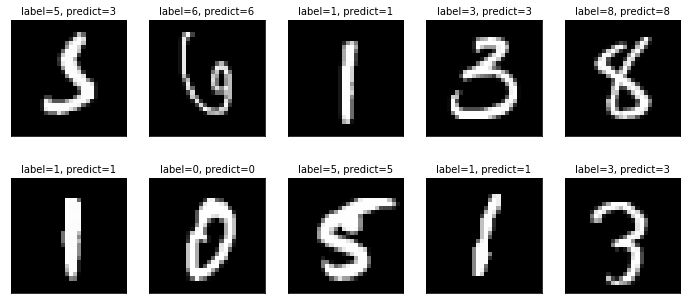

In [0]:
plot_images_labels_prediction(X_test_image, y_test_label, prediction, idx=340)  # 顯示從第340開始的10筆資料(340~349筆)

小結：
發現有部分預測是錯誤的

### 顯示Confusion Matrix(混淆矩陣)

* 機器學習領域中，特別是統計分類的問題，會使用混淆矩陣(又稱誤差矩陣，error matrix)以視覺化方式了解監督式學習演算法是否混淆分類。

#### STEP1. 使用pandas crosstab建立混淆矩陣

In [0]:
pd.crosstab(y_test_label, 
            prediction,
            rownames = ['label'],
            colnames = ['predict']
           )

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,966,0,1,3,1,1,2,1,3,2
1,0,1122,4,1,0,1,3,0,4,0
2,4,1,1005,7,0,0,2,5,8,0
3,0,0,1,999,0,1,0,3,3,3
4,2,0,3,1,955,0,4,3,0,14
5,3,0,0,15,0,859,5,1,5,4
6,5,2,3,1,4,3,939,0,1,0
7,0,5,11,6,1,0,0,987,2,16
8,3,0,4,9,0,2,2,2,950,2


小結：發現預測與實際有誤差、且超過10筆的共有3項
* 預測 = 9, 實際 = 7
* 預測 = 3, 實際 = 5
* 預測 = 2, 實際 = 7

#### STEP2. 建立實際與預測dataframe

In [0]:
df = pd.DataFrame({'label':y_test_label, 'predict':prediction})
df[:2]

,label,predict
0,7,7
1,2,2


#### STEP3. 查詢誤差較多的項目(真實值=7, 預測=9)

In [0]:
df[(df.label == 7)&(df.predict == 9)]

,label,predict
846,7,9
1328,7,9
1494,7,9
1496,7,9
1522,7,9
2024,7,9
2070,7,9
3376,7,9
4027,7,9
4199,7,9


* 取第846項來看看圖像

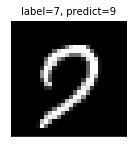

In [0]:
plot_images_labels_prediction(X_test_image,
                              y_test_label,
                              prediction,
                              idx = 846,
                              num = 1
                             )

---

### MLP模型_2 ─ 多層感知器增加隱藏層神經元個數為1000

* 來試試看MLP模型增加隱藏層神經元為1000個會如何？

#### STEP1. 建立模型

In [0]:
model2 = Sequential()

In [0]:
model2.add(Dense(units = 1000,
                 input_dim = 784,
                 kernel_initializer = 'normal',
                 activation = 'relu'
                )
          )

In [0]:
model2.add(Dense(units = 10,
                 kernel_initializer = 'normal',
                 activation = 'softmax'
                )
          )

#### STEP2. 查看模型摘要

In [0]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
None


#### STEP3. 開始訓練

In [0]:
model2.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
              )

In [0]:
train_history2 = model2.fit(x = X_Train_Normalization,
                            y = y_Train_OneHotEncoding,
                            validation_split = 0.2,
                            epochs = 10,
                            batch_size = 200,
                            verbose = 2
                           )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 6s - loss: 0.2952 - acc: 0.9158 - val_loss: 0.1528 - val_acc: 0.9564
Epoch 2/10
 - 6s - loss: 0.1166 - acc: 0.9668 - val_loss: 0.1172 - val_acc: 0.9658
Epoch 3/10
 - 6s - loss: 0.0754 - acc: 0.9788 - val_loss: 0.0946 - val_acc: 0.9717
Epoch 4/10
 - 6s - loss: 0.0525 - acc: 0.9853 - val_loss: 0.0824 - val_acc: 0.9749
Epoch 5/10
 - 6s - loss: 0.0360 - acc: 0.9905 - val_loss: 0.0775 - val_acc: 0.9757
Epoch 6/10
 - 6s - loss: 0.0261 - acc: 0.9933 - val_loss: 0.0737 - val_acc: 0.9773
Epoch 7/10
 - 6s - loss: 0.0183 - acc: 0.9960 - val_loss: 0.0695 - val_acc: 0.9793
Epoch 8/10
 - 6s - loss: 0.0127 - acc: 0.9976 - val_loss: 0.0754 - val_acc: 0.9784
Epoch 9/10
 - 6s - loss: 0.0098 - acc: 0.9984 - val_loss: 0.0728 - val_acc: 0.9793
Epoch 10/10
 - 6s - loss: 0.0078 - acc: 0.9989 - val_loss: 0.0790 - val_acc: 0.9780


#### STEP4. 查看訓練過程的準確率與損失曲線

* 準確率

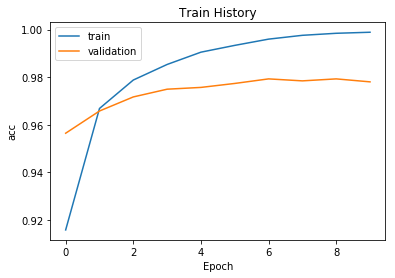

In [0]:
show_train_history(train_history2, 'acc', 'val_acc')

* 損失曲線

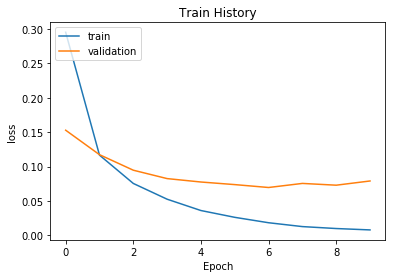

In [0]:
show_train_history(train_history2, 'loss', 'val_loss')

#### STEP5. 預測準確率

In [0]:
scores2 = model2.evaluate(X_Test_Normalization, y_Test_OneHotEncoding)
print()
print('accuracy = ', scores2[1])

10000/10000 [==============================] - 1s 74us/step

accuracy =  0.9793


### MLP模型_3 ─ 多層感知器加入DropOut功能避免Overfitting

* 為了避免過擬合(Overfitting)問題，在MLP中加入DropOut(0.5)指令，可以在每次訓練迭代中隨機在隱藏層放棄50%的神經元，以避免Overfitting

#### STEP1. 匯入DropOut函數

In [0]:
from keras.layers import Dropout

#### STEP2. 修改隱藏層加入DropOut功能

In [0]:
model3 = Sequential()

In [0]:
model3.add(Dense(units = 1000,
                 input_dim = 784,
                 kernel_initializer = 'normal',
                 activation = 'relu'
                )
          )

In [0]:
model3.add(Dropout(0.5))  # 在隱藏層加入DropOut指令

W0804 04:43:47.554220 140501838047104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model3.add(Dense(units = 10,
                 kernel_initializer = 'normal',
                 activation = 'softmax'
                )
          )

#### STEP3. 查看模型摘要

In [0]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
None


#### STEP4. 查看訓練過程中的準確率

In [0]:
model3.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
              )

In [0]:
train_history3 = model3.fit(x = X_Train_Normalization,
                            y = y_Train_OneHotEncoding,
                            validation_split = 0.2,
                            epochs = 10,
                            batch_size = 200,
                            verbose = 2
                           )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 8s - loss: 0.3553 - acc: 0.8942 - val_loss: 0.1613 - val_acc: 0.9552
Epoch 2/10
 - 8s - loss: 0.1586 - acc: 0.9540 - val_loss: 0.1196 - val_acc: 0.9651
Epoch 3/10
 - 7s - loss: 0.1149 - acc: 0.9654 - val_loss: 0.1001 - val_acc: 0.9704
Epoch 4/10
 - 7s - loss: 0.0925 - acc: 0.9721 - val_loss: 0.0924 - val_acc: 0.9716
Epoch 5/10
 - 8s - loss: 0.0763 - acc: 0.9769 - val_loss: 0.0820 - val_acc: 0.9753
Epoch 6/10
 - 7s - loss: 0.0636 - acc: 0.9806 - val_loss: 0.0756 - val_acc: 0.9771
Epoch 7/10
 - 7s - loss: 0.0553 - acc: 0.9836 - val_loss: 0.0755 - val_acc: 0.9775
Epoch 8/10
 - 8s - loss: 0.0471 - acc: 0.9858 - val_loss: 0.0709 - val_acc: 0.9792
Epoch 9/10
 - 7s - loss: 0.0410 - acc: 0.9872 - val_loss: 0.0673 - val_acc: 0.9793
Epoch 10/10
 - 7s - loss: 0.0367 - acc: 0.9886 - val_loss: 0.0654 - val_acc: 0.9804


#### STEP5. 查看訓練過程的準確率與損失曲線

* 準確率

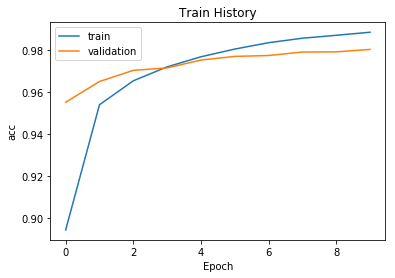

In [0]:
show_train_history(train_history3, 'acc', 'val_acc')

* 損失曲線

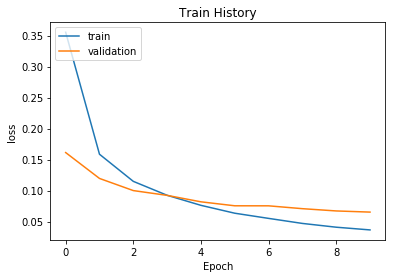

In [0]:
show_train_history(train_history3, 'loss', 'val_loss')

#### step6. 查看準確率

In [0]:
scores3 = model3.evaluate(X_Test_Normalization, y_Test_OneHotEncoding)
print()
print('accuracy = ', scores3[1])

10000/10000 [==============================] - 1s 120us/step

accuracy =  0.9821


### MLP模型_4  ─ 建立含兩個隱藏層的多元感知器

* 為了進一步增加準確率，這邊多建一個隱藏層試試看

#### STEP1. 建立模型

In [0]:
model4 = Sequential()

In [0]:
model4.add(Dense(units = 1000,
                 input_dim = 784,
                 kernel_initializer = 'normal',
                 activation = 'relu'
                )
          )

In [0]:
model4.add(Dropout(0.5))

In [0]:
model4.add(Dense(units = 1000,
                 kernel_initializer = 'normal',
                 activation = 'relu'
                )
          )

In [0]:
model4.add(Dropout(0.5))

In [0]:
model4.add(Dense(units = 10,
                 kernel_initializer = 'normal',
                 activation = 'softmax'
                )
          )

#### STEP2. 查看模型層別摘要

In [0]:
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________
None


#### STEP3. 查看訓練過程

In [0]:
model4.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy']
              )

In [0]:
train_history4 = model4.fit(x = X_Train_Normalization,
                            y = y_Train_OneHotEncoding,
                            validation_split = 0.2,
                            epochs = 10,
                            batch_size = 200,
                            verbose = 2
                           )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 16s - loss: 0.3735 - acc: 0.8826 - val_loss: 0.1383 - val_acc: 0.9585
Epoch 2/10
 - 16s - loss: 0.1626 - acc: 0.9503 - val_loss: 0.1112 - val_acc: 0.9662
Epoch 3/10
 - 16s - loss: 0.1237 - acc: 0.9612 - val_loss: 0.0903 - val_acc: 0.9718
Epoch 4/10
 - 16s - loss: 0.1002 - acc: 0.9692 - val_loss: 0.0864 - val_acc: 0.9724
Epoch 5/10
 - 16s - loss: 0.0842 - acc: 0.9733 - val_loss: 0.0769 - val_acc: 0.9776
Epoch 6/10
 - 16s - loss: 0.0739 - acc: 0.9761 - val_loss: 0.0760 - val_acc: 0.9762
Epoch 7/10
 - 16s - loss: 0.0657 - acc: 0.9787 - val_loss: 0.0737 - val_acc: 0.9790
Epoch 8/10
 - 16s - loss: 0.0601 - acc: 0.9799 - val_loss: 0.0795 - val_acc: 0.9787
Epoch 9/10
 - 16s - loss: 0.0553 - acc: 0.9824 - val_loss: 0.0841 - val_acc: 0.9768
Epoch 10/10
 - 16s - loss: 0.0520 - acc: 0.9828 - val_loss: 0.0788 - val_acc: 0.9788


#### STEP4. 查看訓練過程中的準確率

* 準確率

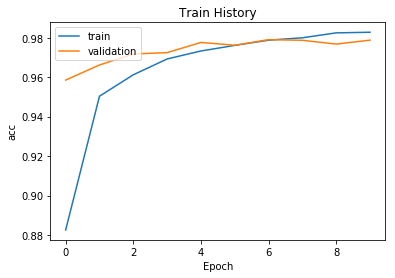

In [0]:
show_train_history(train_history4, 'acc', 'val_acc')

* 小結：試了4個模型，在新增隱藏層為2層以及增加隱藏層DropOut後，準確率不一定是最好，但有效對策Overfitting